## Setup and Installations

In [1]:

pip install shap


   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   -- ------------------------------------- 30.7/545.3 kB 1.3 MB/s eta 0:00:01
   --- ----------------------------------- 51.2/545.3 kB 650.2 kB/s eta 0:00:01
   ------- ------------------------------ 102.4/545.3 kB 737.3 kB/s eta 0:00:01
   ----------- -------------------------- 163.8/545.3 kB 893.0 kB/s eta 0:00:01
   ----------------- ---------------------- 235.5/545.3 kB 1.0 MB/s eta 0:00:01
   --------------------- ------------------ 286.7/545.3 kB 1.1 MB/s eta 0:00:01
   ------------------------- -------------- 348.2/545.3 kB 1.1 MB/s eta 0:00:01
   ----------------------------- ---------- 399.4/545.3 kB 1.1 MB/s eta 0:00:01
   ----------------------------------- ---- 481.3/545.3 kB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 545.3/545.3 kB 1.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.2/2.8 MB 4.9 MB


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import Required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import shap


In [4]:

df = pd.read_csv(r"C:\WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## Basic EDA (Exploratory Data Analysis)

Shape: (1470, 35)
Missing Values:
 Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
Years

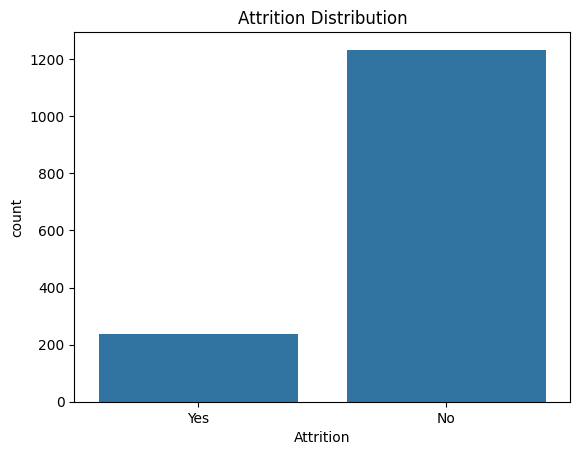

In [5]:
print("Shape:", df.shape)
print("Missing Values:\n", df.isnull().sum())
print("\nAttrition Value Counts:\n", df['Attrition'].value_counts())

sns.countplot(x='Attrition', data=df)
plt.title("Attrition Distribution")
plt.show()


## Data Preprocessing

In [6]:
# Label Encode Attrition Column
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Drop columns that don’t add value
df.drop(['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber'], axis=1, inplace=True)

# One-Hot Encoding
df = pd.get_dummies(df, drop_first=True)

# Split into X and y
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


##  Train Random Forest Model

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.97      0.91       247
           1       0.42      0.11      0.17        47

    accuracy                           0.83       294
   macro avg       0.63      0.54      0.54       294
weighted avg       0.78      0.83      0.79       294



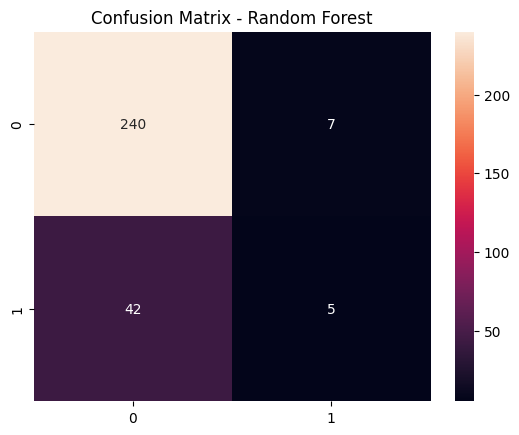

In [7]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.title("Confusion Matrix - Random Forest")
plt.show()


In [9]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test)

# Check number of classes and shapes
print(f"Classes: {len(shap_values)}")
print(f"SHAP[0] shape: {shap_values[0].shape}, SHAP[1] shape: {shap_values[1].shape}")
print(f"X_test shape: {X_test.shape}")

# If binary classification, choose the one with shape == X_test.shape
for i in range(len(shap_values)):
    if shap_values[i].shape == X_test.shape:
        shap.summary_plot(shap_values[i], X_test, plot_type="bar")


Classes: 294
SHAP[0] shape: (44, 2), SHAP[1] shape: (44, 2)
X_test shape: (294, 44)


##  Key Insights from Employee Attrition Prediction

### 1.  OverTime is a Strong Indicator of Attrition
Employees who work overtime are much more likely to leave the company. Reducing overtime or offering better compensation may reduce attrition.

### 2.  Monthly Income Affects Retention
Employees with lower monthly income show higher attrition rates. Fair and performance-based compensation structures can help retain employees.

### 3.  Job Satisfaction & Environment Satisfaction Matter
Employees reporting low satisfaction with their job or work environment are more likely to leave. HR should focus on increasing workplace engagement and satisfaction.

### 4.  Younger Employees Tend to Leave Early
Employees in the age group of 18–30 and those with fewer years at the company are more prone to attrition. Improved onboarding and early mentorship can help.

### 5. Certain Job Roles Have Higher Turnover
Sales Representatives and Laboratory Technicians show higher attrition. These roles may require job-specific improvements or retention programs.

### 6.  Frequent Business Travel Slightly Impacts Attrition
Frequent travelers show slightly higher chances of leaving. Consider providing flexibility or reducing travel load.

### 7.  Years with Current Manager Influences Stability
Employees who have spent less time with their current manager are more likely to leave, indicating that consistent management may promote employee retention.

---
